In [1]:
# import packages
import pandas as pd
import numpy as np

import swifter
import great_expectations as ge

In [2]:
# import datasets
train_X = pd.read_csv('/Users/eesoonhang/Desktop/capstone_data/train_in_encodedToNacSeq.csv', usecols=lambda x: x!= '*Unnamed*')
train_y = pd.read_csv('/Users/eesoonhang/Desktop/capstone_data/train_out.csv', usecols=lambda x: x!= '*Unnamed*')
test_X = pd.read_csv('/Users/eesoonhang/Desktop/capstone_data/test_in_encodedToNacSeq.csv', usecols=lambda x: x!= '*Unnamed*')
test_y = pd.read_csv('/Users/eesoonhang/Desktop/capstone_data/test_out.csv', usecols=lambda x: x!= '*Unnamed*')

# split to respective input datasets
train_X_nac = train_X.iloc[:, 0:4]
train_X_dac = train_X.iloc[:, 4:20]
train_X_tac = train_X.iloc[:, 20:]
test_X_nac = test_X.iloc[:, 0:4]
test_X_dac = test_X.iloc[:, 4:20]
test_X_tac = test_X.iloc[:, 20:]

# compressed output y
# transform target >=1 to 1
def normalize_output(x):
    return np.where(x.target>1, x.target/x.target, x.target)
    
# compressed y-variable
compressed_train_y = train_y.sum(axis=1).to_frame(name='target')
compressed_test_y = test_y.sum(axis=1).to_frame(name='target')
compressed_train_y.target = compressed_train_y.swifter.apply(normalize_output, axis=1)
compressed_test_y.target = compressed_test_y.swifter.apply(normalize_output, axis=1)

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import math

def train_Model(n_rfe_features):
    
    print('Number of features to be selected: ' , n_rfe_features)
    
    print('scaling data')
    # apply scaler
    scaler = StandardScaler()
    train_X_scaled = scaler.fit_transform(train_X, compressed_train_y)
    train_X_scaled = pd.DataFrame(train_X_scaled, columns=train_X.columns)
    X_train, X_valid, Y_train, Y_valid = train_test_split(train_X_scaled, compressed_train_y, test_size = 0.5, random_state = 1234, stratify=compressed_train_y)
    X_train.shape
    
    print('selecting feature via RFE..')
    # instantiate model
    rfc = RandomForestClassifier(n_estimators=100)
    rfe = RFE(estimator = rfc, n_features_to_select = n_rfe_features, step = 1)
    # apply RFE
    rfe.fit(X_train, Y_train.values.ravel())
    
    print('refactoring dataset...')
    # refactor train_X and test_X with rfe
    rfe_train_X = rfe.transform(X_train)
    rfe_valid_X = rfe.transform(X_valid)
    
    print('fit model...')
    # Perform RandomForestClassification
    rfc.fit(rfe_train_X, Y_train.values.ravel())
    y_predict = rfc.predict(rfe_valid_X)
    
    print('evaluate model...')
    # print ranking based on rfe
    columns = X_train.columns
    ranking = rfe.ranking_
    rfe_selected = pd.concat([pd.DataFrame(columns), 
                              pd.DataFrame(ranking)], axis=1)
    rfe_selected.columns = ['Feature Name', 'Ranking']
    print('rankings: ' + str(ranking) + '\n' + 'RFE selected features: \n' + '-'*20 + '\n' + str(rfe_selected[(rfe_selected.Ranking == 1)]['Feature Name']))

    rmse = math.sqrt(mean_squared_error(Y_valid, y_predict))
    print('rmse: %4.2f' %rmse)
    
    score = rfc.score(rfe_valid_X, Y_valid)
    print('score: %4.2f' %score)
    
    return n_rfe_features, rmse, score, rfc, rfe, scaler

In [10]:
# train model
%time model = train_Model(33)

Number of features to be selected:  33
scaling data
selecting feature via RFE..
refactoring dataset...
fit model...
evaluate model...
rankings: [ 1  1  1  1  1  1  7  1  1  1  1  2  1  1  1  1  1  1  1  1  1 10  1 15
 23 35 19 29 25 33  1 30  1 46 31  1 14 27 16 28 38  5  1 37  1 43  9 51
 42  3 26 12  1  1  1 34 41 36 52 47 11  4  1 17 48 50 21 40  8 49  1  6
 22 44 45 20 24 39 32 13  1  1 18  1]
RFE selected features: 
--------------------
0       A
1       C
2       G
3       T
4      AA
5      AC
7      AT
8      CA
9      CC
10     CG
12     GA
13     GC
14     GG
15     GT
16     TA
17     TC
18     TG
19     TT
20    AAA
22    AAG
30    AGG
32    ATA
35    ATT
42    CCG
44    CGA
52    GAA
53    GAC
54    GAG
62    GGG
70    TAG
80    TTA
81    TTC
83    TTT
Name: Feature Name, dtype: object
rmse: 0.45
score: 0.80
CPU times: user 45min 50s, sys: 16.9 s, total: 46min 7s
Wall time: 46min 19s


In [11]:
# export the model
import pickle 
pickle.dump(model[3], open('/Users/eesoonhang/Desktop/capstone_data/RFC_100trees_withRFE33.pkl', 'wb'))
pickle.dump(model[4], open('/Users/eesoonhang/Desktop/capstone_data/RFE_33.pkl', 'wb'))

In [12]:
# evaluate accuracy
clf = model[3]
rfe = model[4]
scaler = model[5]
test_X_scaled = scaler.transform(test_X)
rfe_test_X = rfe.transform(test_X_scaled)
clf.score(rfe_test_X, compressed_test_y)

0.7566666666666667

Text(0.5, 427.9555555555555, 'Predicted label')

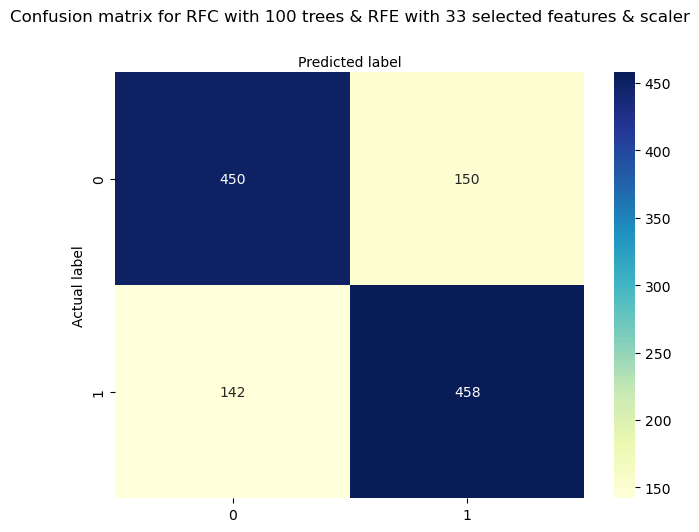

In [13]:
from sklearn.metrics import confusion_matrix as cfm
import matplotlib.pyplot as plt
import seaborn as sns
# visualize confusion matrix
cnf_matrix = cfm(compressed_test_y, clf.predict(rfe_test_X)) 
class_names=[0,1] # name  of classes
fig, ax = plt.subplots() 
tick_marks = np.arange(len(class_names)) 
plt.xticks(tick_marks, class_names) 
plt.yticks(tick_marks, class_names) 

# create heatmap 
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g') 
ax.xaxis.set_label_position("top") 
plt.tight_layout() 
plt.title('Confusion matrix for RFC with 100 trees & RFE with 33 selected features & scaler', y=1.1) 
plt.ylabel('Actual label') 
plt.xlabel('Predicted label')